In [1]:
import sys
sys.path.append('../../')
from CMRx4DFlowMaskGeneration import *
sys.path.append('../')
from Utils import *
from einops import rearrange


In [2]:
# Read one case from a folder that contains the corresponding .mat files
data_dir = '/mnt/nas/nas3/openData/rawdata/4dFlow/Aorta/Center012/Philips_30T_Ingenia/vn4/'

# load_data takes the case directory (where the .mat files are located) as input
# Returned objects are lazy h5 handles (h5py-style); data is not loaded into memory until indexed
kdata_full = load_data(data_dir + '/kdata_full.mat', key='kdata_full')
coilmap = load_data(data_dir + '/coilmap.mat', key='coilmap')
segmask = load_data(data_dir + '/segmask.mat', key='segmask')
params = read_params_csv(data_dir + '/params.csv')

# For h5 datasets, use [()] to materialize the full array into RAM as a NumPy array
kdata_full = kdata_full['real'][()] + 1j * kdata_full['imag'][()]
coilmap = coilmap['real'][()] + 1j * coilmap['imag'][()]
segmask = segmask[()]

VENC = np.array(params['VENC'])
VOrder = params['venc_order']
# k-space data shape: (Nv, Nt, SPE, PE, FE)
Nv, Nt, Nc, SPE, PE, FE = kdata_full.shape

img = np.sum(k2i_numpy(kdata_full, ax=[-1, -2, -3]) * np.conj(coilmap), axis=-4)
Nv, Nt, SPE, PE, FE = img.shape

In [3]:
img_csllr = load_data('../2_CompressedSensingDemo/img_csllr.mat', key='img_csllr')
img_csllr = img_csllr['real'][()] + 1j * img_csllr['imag'][()]

In [4]:
corr_maps = execute_MSAC(img, corr_fit_order=3, th=0.1)
img_corr = img.copy()
img_corr[1:] *= np.exp(1j * -corr_maps)
mag_gt, flow_gt = complex2magflow(img_corr, venc=VENC)

In [5]:
img_csllr_corr = img_csllr.copy()
img_csllr_corr[1:] *= np.exp(1j * -corr_maps)
mag_csllr, flow_csllr = complex2magflow(img_csllr_corr, venc=VENC)

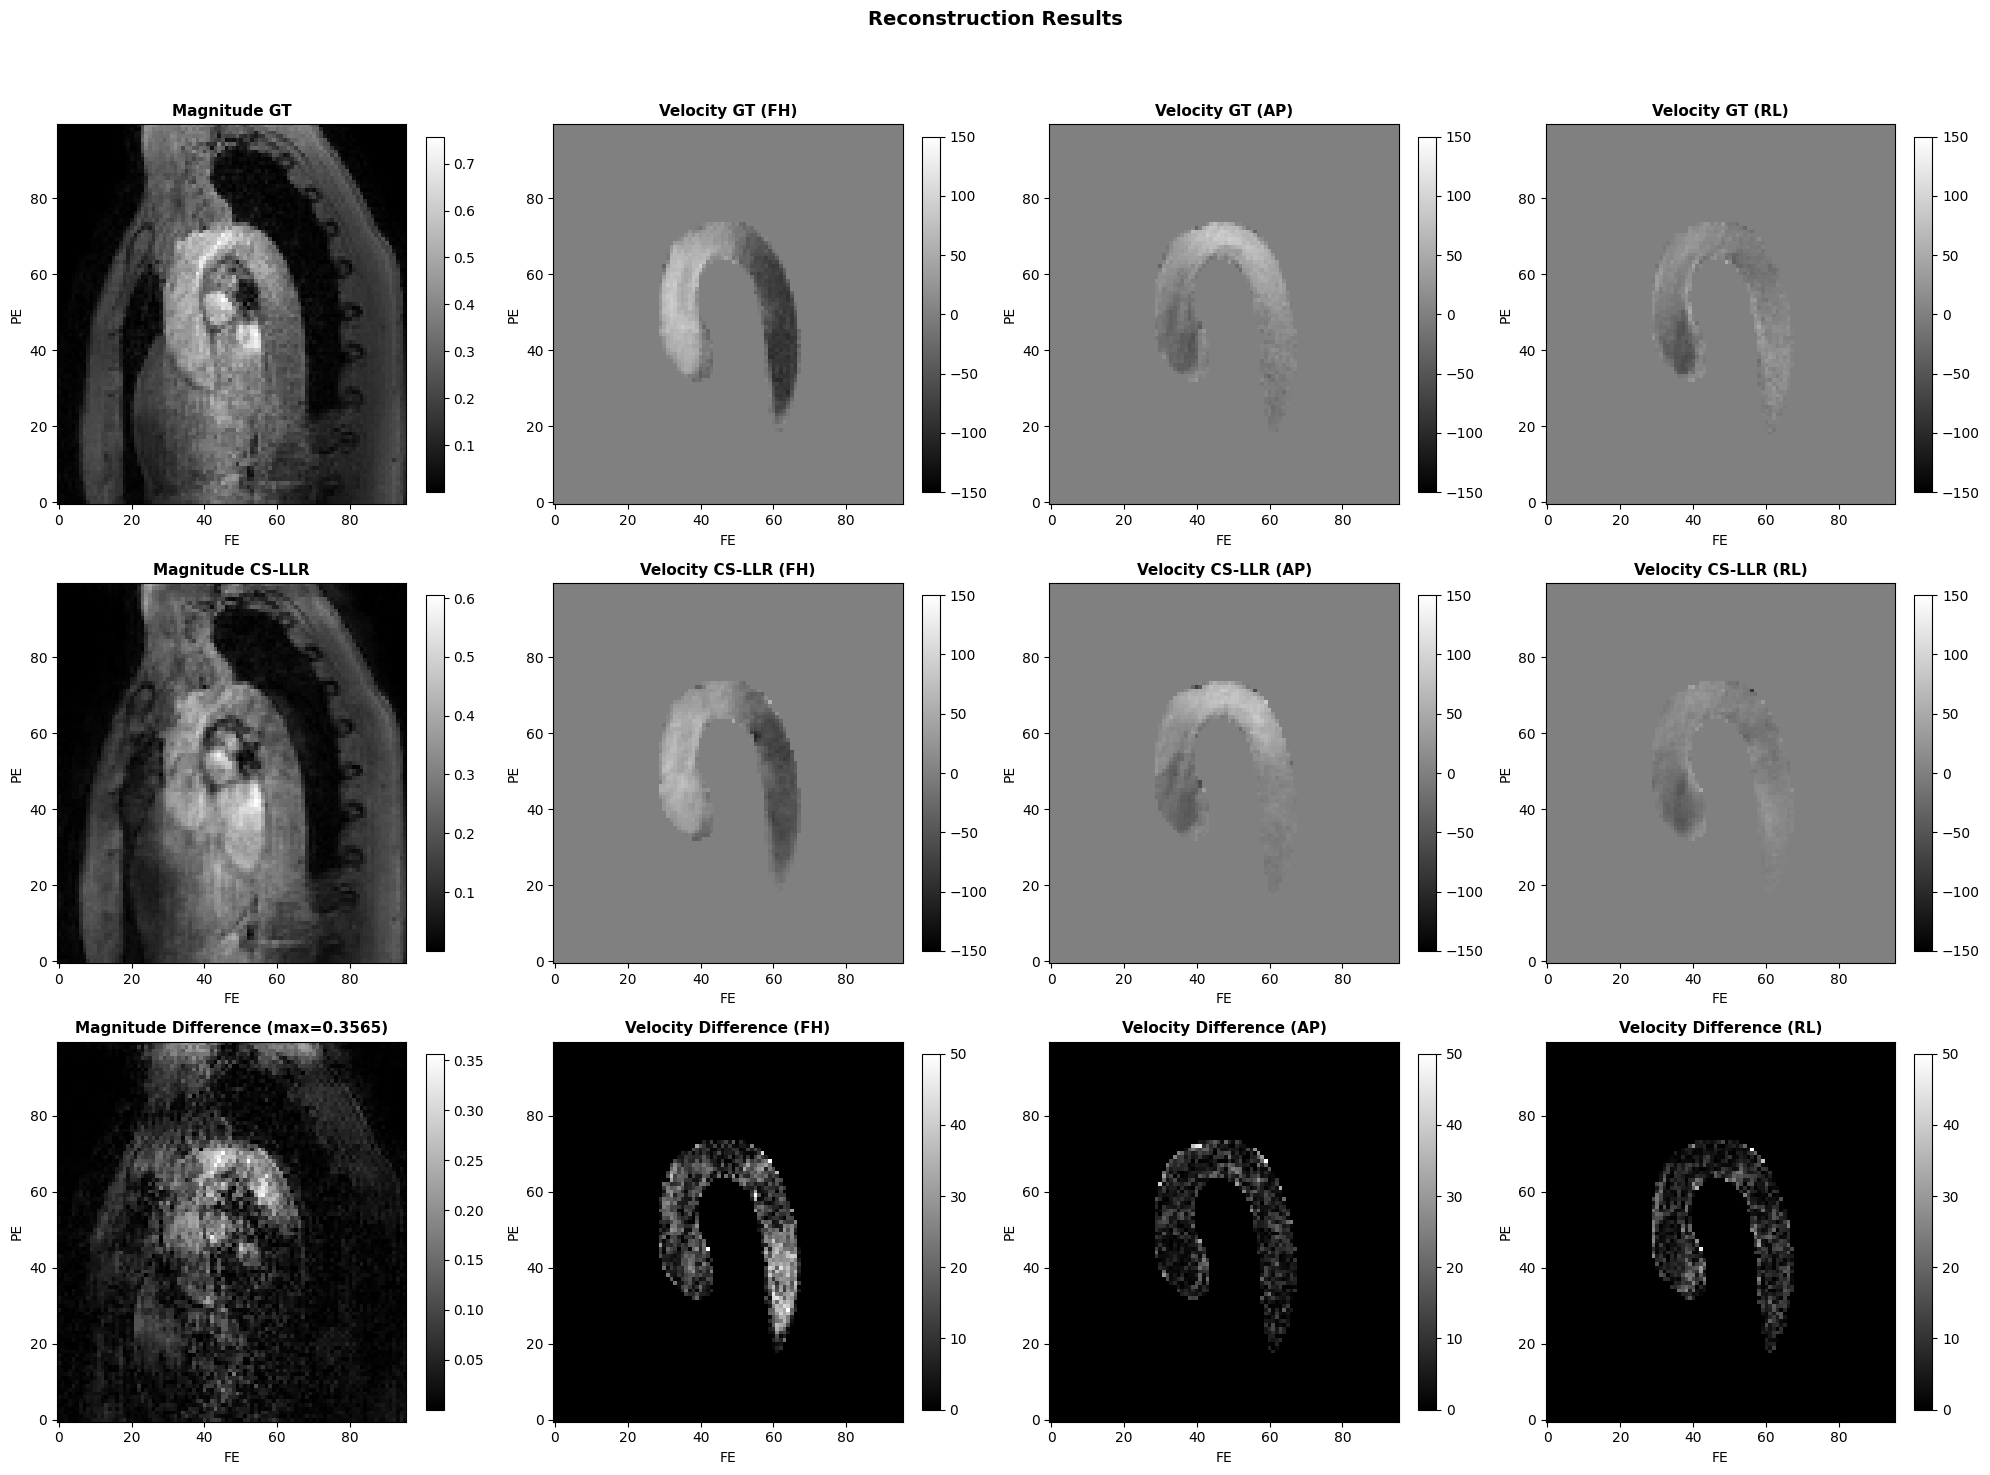

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# shapes: (Nv, Nt, SPE, PE, FE)
showz = mag_gt.shape[2] // 2   # SPE index
showt = 3                      # Nt index
showv = 0                      # pick v for magnitude (if Nv>1)

row, col = 3, 4
fig = plt.figure(figsize=(20, 15))
fig.suptitle(
    f'Reconstruction Results',
    fontsize=14, fontweight='bold'
)

def imshow_pefe(ax, img2d, title, vmin=None, vmax=None):
    im = ax.imshow(
        img2d, cmap='gray', origin='lower', aspect='auto',
        vmin=vmin, vmax=vmax
    )
    ax.set_title(title, fontsize=11, fontweight='bold')
    ax.set_xlabel("FE")
    ax.set_ylabel("PE")
    plt.colorbar(im, ax=ax, fraction=0.046)
    return im

# ---------------- Row 1: GT ----------------
ax1 = plt.subplot(row, col, 1)
imshow_pefe(ax1, np.abs(mag_gt[showv, showt, showz, :, :]).T, "Magnitude GT")

for i in range(3):
    ax = plt.subplot(row, col, i + 2)
    imshow_pefe(
        ax,
        (flow_gt[i, showt, showz, :, :] * segmask[showz]).T.astype(np.float32),
        f"Velocity GT ({VOrder[i]})",
        vmin=-VENC[i], vmax=VENC[i]
    )

# ---------------- Row 2: CSLLR ----------------
ax5 = plt.subplot(row, col, 5)
imshow_pefe(ax5, np.abs(mag_csllr[showv, showt, showz, :, :]).T, "Magnitude CS-LLR")

for i in range(3):
    ax = plt.subplot(row, col, i + 6)
    imshow_pefe(
        ax,
        (flow_csllr[i, showt, showz, :, :] * segmask[showz]).T.astype(np.float32),
        f"Velocity CS-LLR ({VOrder[i]})",
        vmin=-VENC[i], vmax=VENC[i]
    )

# ---------------- Row 3: Difference maps ----------------
mag_diff = np.abs(np.abs(mag_csllr) - np.abs(mag_gt))[showv, showt, showz, :, :]
ax9 = plt.subplot(row, col, 9)
imshow_pefe(ax9, mag_diff.T, f"Magnitude Difference (max={mag_diff.max():.4f})")

for i in range(3):
    ax = plt.subplot(row, col, i + 10)
    flow_diff = np.abs(flow_csllr - flow_gt)[i, showt, showz, :, :] * segmask[showz]
    imshow_pefe(
        ax,
        flow_diff.T.astype(np.float32),
        f"Velocity Difference ({VOrder[i]})",
        vmin=0, vmax=VENC[i] / 3
    )

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [7]:
# --- Quality metrics (CS-LLR reconstruction vs. Ground Truth) ---
# SSIM   in [0, 1]   (higher is better)
# nRMSE  in [0, 1]   (lower is better)
# RelErr in [0, 1]   (lower is better; evaluated inside segmask)
# AngErr in degrees (°) (lower is better; evaluated inside segmask)

ssim_val   = SSIM(mag_csllr, mag_gt)
nrmse_val  = nRMSE(mag_csllr, mag_gt)
relerr_val = RelErr(flow_csllr, flow_gt, segmask)
angerr_val = AngErr(flow_csllr, flow_gt, segmask)

print(f"SSIM   (mag, 0–1): {ssim_val:.6f}")
print(f"nRMSE  (mag, 0–1): {nrmse_val:.6f}")
print(f"RelErr (flow, 0–1, masked): {relerr_val:.6f}")
print(f"AngErr (flow, °, masked): {angerr_val:.3f}°")

SSIM   (mag, 0–1): 0.851095
nRMSE  (mag, 0–1): 0.050498
RelErr (flow, 0–1, masked): 0.399597
AngErr (flow, °, masked): 38.110°
